# Anomaly Detection
Given a set of similated financial transaction data, develop a model to flag individual transactions for likely fraudulent activity.

## Data Import

Prep libraries and load raw data that was previously uploaded to S3 into current working session.

In [91]:
import pandas as pd
import boto3
import numpy as np
import seaborn as sns
import os

from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import time

In [36]:
bucket = 'anomaly-credit-cards'
prefix = 'knn'
output_prefix = prefix

s3 = boto3.Session().resource('s3')
s3.Bucket('anomaly-credit-cards').download_file('paysim1.zip', 'data.zip')

In [6]:
!unzip data.zip

Archive:  data.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [10]:
!mv *_log.csv data.csv

In [26]:
df = pd.read_csv('data.csv')
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## Feature Engineering

The type field only has 4 categories, so we'll definitely do some one hot encoding on that.

The origin and destination names aren't discrete categories, but may be worth flagging high-activity accounts.  The overall fraud rate in the data set is roughly 1 in 775 cases, so heavy drivers should be pretty rare.  Can we find a visible drop-off somewhere in the top 5% most common accounts?

In [ ]:
cutoff = int(len(df.index)*0.05)
print('Cutoff is '+str(cutoff))
orig_counts = df['nameOrig'].value_counts()[:cutoff]

In [8]:
print(orig_counts)

C545315117     3
C1065307291    3
C2051359467    3
C1999539787    3
C363736674     3
C1976208114    3
C1530544995    3
C1677795071    3
C724452879     3
C1832548028    3
C1902386530    3
C1462946854    3
C400299098     3
C1784010646    3
C2098525306    3
C1119060051    2
C1541715508    2
C435002653     2
C1909645447    2
C1341083738    2
C297700036     2
C1926119720    2
C1921127999    2
C944841858     2
C763156609     2
C165632088     2
C1789828014    2
C1604096347    2
C962758787     2
C337535091     2
              ..
C176846586     1
C732360133     1
C163453463     1
C1399117318    1
C1969970778    1
C759231075     1
C205156757     1
C838506983     1
C1355126358    1
C729335958     1
C95165866      1
C764707841     1
C1732951589    1
C334098160     1
C1954036976    1
C1797248012    1
C566610816     1
C1440828139    1
C433389061     1
C238431646     1
C1011261111    1
C1663485546    1
C932481949     1
C498354044     1
C776107744     1
C1934934372    1
C1366331550    1
C1493394574   

In [9]:
dest_counts = df['nameDest'].value_counts()[:cutoff]
print(dest_counts)

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
C248609774     101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
C977993101      96
C97730845       96
C392292416      95
C1899073220     92
C306206744      91
C1782113663     90
C1234776885     90
C998351292      89
C716083600      89
C909295153      88
C667346055      86
C1674899618     86
C1262822392     85
C453211571      84
C1255024717     84
C1816757085     84
C2006081398     83
C932583850      82
C991363637      82
C1504109395     82
              ... 
C253277468       4
C2057368166      4
C1789014986      4
C202553345       4
C505476967       4
C741108693       4
C119525783       4
C795744917       4
C435534972       4
C1487629747      4
C953293469       4
C1836871228      4
C867568334       4
C1563231153      4
C1607385625      4
C244339910       4
C151600596       4
C2084319523      4
C400435865       4
C2129614553      4
C31115617        4
C1487309848 

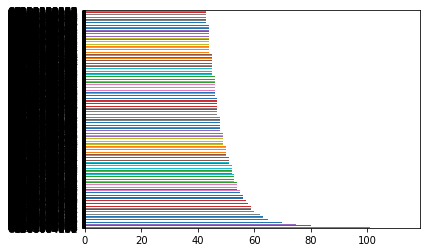

In [14]:
dest_counts[:int(cutoff*0.01)].plot(kind='barh')

Looks like origins rarely repeat, so that can probably be dropped completely.  The destination does drop off pretty heavily by that 5% mark.  Maybe flagging anyone who appears >60x?

Also, the amount, old balance, and new balance are redundant.  We can drop the new balance columns and still have complete information.

Finally, the step column (our proxy for the progression of time) probably won't apply in single-transaction checks later, so I'll try to live without it.

In [28]:
df['repeatDest'] = np.where(dest_counts[df['nameOrig']] > 60, 1, 0)
print(df.head())
model_data = pd.get_dummies(df.drop(['nameOrig', 'nameDest', 'newbalanceOrig', 'newbalanceDest', 'step'], axis=1))
print(model_data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   repeatDest  
0           0  
1           0  
2           0  
3           0  
4           0  
  

Now that there's some reasonably clean data, let's split it up and prep for training.

In [ ]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.9 * len(model_data))])

pd.concat([train_data['isFraud'], train_data.drop(['isFraud'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([test_data['isFraud'], test_data.drop(['isFraud'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

In [32]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(output_prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(output_prefix, 'test/test.csv')).upload_file('test.csv')

## Tune a K-Nearest Neighbor Model

### Train and Predict

We need to build a KNN estimator and train it up on our training data.  Then we need to evaluate its performance based on our testing data.  The estimator will be classify as fraud or not-fraud.

In [43]:
## Ripped from the Sagemaker k_nearest_neighbors_covtype example

import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.amazon.amazon_estimator import get_image_uri

s3_train_data = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='text/csv')
s3_test_data = sagemaker.s3_input(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='text/csv')

def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data, 
    and return a deployed predictor
    
    """

    # set up the estimator, split it across a few instances since the dataset is large-ish
    knn = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        train_instance_count=4,
        train_instance_type='ml.m4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())
    knn.set_hyperparameters(**hyperparams)
    
    # train a model. fit_input contains the locations of the train and test data
    fit_input = {'train': s3_train_data}
    if s3_test_data is not None:
        fit_input['test'] = s3_test_data
    knn.fit(fit_input)
    return knn

In [35]:
def predictor_from_hyperparams(knn_estimator, estimator_name, instance_type, endpoint_name=None): 
    knn_predictor = knn_estimator.deploy(initial_instance_count=1, instance_type=instance_type,
                                        endpoint_name=endpoint_name)
    knn_predictor.content_type = 'text/csv'
    knn_predictor.serializer = csv_serializer
    knn_predictor.deserializer = json_deserializer
    return knn_predictor

### Building Jobs

Given the relative scarcity of fraudulent transactions, we'll probably need to use a fairly large sample size in order to avoid the possibility of generating samples with no fraud at all.

We'll also look at two different FAISS indexes: FlatL2 for exact results and a clustered flat to see if we can get some performance boost without sacrificing accuracy.  Since we're looking at aroun 6M vectors and I'm willing to work on without a GPU, [Facebook's Guidelines](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index) would suggest `IVF65536_HNSW32,Flat`. We'll go with the general `IVFFlat`, keep the defaults for the related hyperparams, and let the engine decide.

In [44]:
hyperparams_flat_l2 = {
    'feature_dim': 10,
    'k': 100,
    'sample_size': 1000000,
    'predictor_type': 'classifier' 
}
output_path_flat_l2 = 's3://' + bucket + '/' + prefix + '/flat_l2/output'
knn_estimator_flat_l2 = trained_estimator_from_hyperparams(s3_train_data, hyperparams_flat_l2, 
                                                           output_path_flat_l2, s3_test_data=s3_test_data)

INFO:sagemaker:Creating training-job with name: knn-2018-12-20-19-34-15-131


2018-12-20 19:34:15 Starting - Starting the training job...
2018-12-20 19:34:18 Starting - Launching requested ML instances......
2018-12-20 19:35:22 Starting - Preparing the instances for training.........
2018-12-20 19:37:06 Downloading - Downloading input data...
2018-12-20 19:37:32 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[12/20/2018 19:37:33 INFO 140152469702464] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[12/20/2018 19:37:33 INFO 140152469702464] Reading provided configuration from /opt/ml/i

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 0, "sum": 0.0, "min": 0}}, "EndTime": 1545334656.32054, "Dimensions": {"Host": "algo-4", "Meta": "init_train_data_iter", "Operation": "training", "Algorithm": "AWS/KNN"}, "StartTime": 1545334656.32049}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "To


2018-12-20 19:49:57 Uploading - Uploading generated training model
2018-12-20 19:50:05 Completed - Training job completed
Billable seconds: 3119


In [45]:
hyperparams_ivf_l2 = {
    'feature_dim': 10,
    'k': 100,
    'sample_size': 1000000,
    'predictor_type': 'classifier',
    'index_type': 'faiss.IVFFlat'
}
output_path_ivf_l2 = 's3://' + bucket + '/' + prefix + '/ivf_l2/output'
knn_estimator_ivf_l2 = trained_estimator_from_hyperparams(s3_train_data, hyperparams_ivf_l2, output_path_ivf_l2, 
                                                          s3_test_data=s3_test_data)

INFO:sagemaker:Creating training-job with name: knn-2018-12-20-19-53-27-752


2018-12-20 19:53:27 Starting - Starting the training job...
2018-12-20 19:53:30 Starting - Launching requested ML instances............
2018-12-20 19:55:30 Starting - Preparing the instances for training......
2018-12-20 19:56:53 Downloading - Downloading input data...
2018-12-20 19:57:16 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[12/20/2018 19:57:17 INFO 139746834392896] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[12/20/2018 19:57:17 INFO 1397468343

[12/20/2018 19:57:30 INFO 140513744906048] push reservoir to kv... 4 num_workers 2 rank
[12/20/2018 19:57:30 INFO 139746834392896] push reservoir to kv... 4 num_workers 1 rank
[12/20/2018 19:57:30 INFO 139746834392896] ...done (250000)
[12/20/2018 19:57:30 INFO 139746834392896] #progress_metric: host=algo-2, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Number of Batches Since Last Reset": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Number of Records Since Last Reset": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Total Batches Seen": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Total Records Seen": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Max Records Seen Between Resets": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Reset Count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1545335850.80165, "Dim


2018-12-20 19:59:53 Uploading - Uploading generated training model
2018-12-20 19:59:53 Completed - Training job completed
Billable seconds: 719


### Evaluation

From here, we'll use the verbose KNN API to obtain the predictions for multiple k values and thereby derive some quality score for each.  We'll also look at the latency, and evaluate across both dimensions.

In [47]:
## Again, ripped from the Sagemaker k_nearest_neighbors_covtype example
def scores_for_ks(test_labels, knn_labels, ks):
    f1_weight = []
    f1_macro = []
    f1_micro = []
    acc = []
    for k in ks:
        pred_k = stats.mode(knn_labels[:,:k], axis=1)[0].reshape((-1,))
        f1_weight.append(f1_score(test_labels, pred_k, average='weighted'))
        f1_macro.append(f1_score(test_labels, pred_k, average='macro'))
        f1_micro.append(f1_score(test_labels, pred_k, average='micro'))
        acc.append(accuracy_score(test_labels, pred_k))
    return {'f1_weight': f1_weight, 'f1_macro': f1_macro, 'f1_micro': f1_micro, 'accuracy': acc, }

def plot_prediction_quality(scores, ks):
    colors = ['r-', 'b-', 'g-','y-'][:len(scores)]
    for (k,v), color in zip(scores.items(), colors):
        plt.plot(ks, v, color, label=k)
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('prediction quality')
    plt.show()

def evaluate_quality(predictor, test_features, test_labels, model_name, verbose=True, num_batches=100):
    """
    Evaluate quality metrics of a model on a test set. 
    """
    # tune the predictor to provide the verbose response
    predictor.accept = 'application/json; verbose=true'
    
    # split the test data set into num_batches batches and evaluate using prediction endpoint. 
    print('running prediction (quality)...')
    batches = np.array_split(test_features, num_batches)
    knn_labels = []
    for batch in batches:
        pred_result = predictor.predict(batch)
        cur_knn_labels = np.array([pred_result['predictions'][i]['labels'] for i in range(len(pred_result['predictions']))])
        knn_labels.append(cur_knn_labels)
    knn_labels = np.concatenate(knn_labels)
    print('running prediction (quality)... done')

    # figure out different k values
    top_k = knn_labels.shape[1]
    ks = range(1, top_k+1)
    
    # compute scores for the quality of the model for each value of k
    print('computing scores for all values of k... ')
    quality_scores = scores_for_ks(test_labels, knn_labels, ks)
    print('computing scores for all values of k... done')
    if verbose:
        plot_prediction_quality(quality_scores, ks)
    
    return quality_scores

def evaluate_latency(predictor, test_features, test_labels, model_name, verbose=True, num_batches=100):
    """
    Evaluate the run-time of a model on a test set.
    """
    # tune the predictor to provide the non-verbose response
    predictor.accept = 'application/json'
    
    # latency for large batches:
    # split the test data set into num_batches batches and evaluate the latencies of the calls to endpoint. 
    print('running prediction (latency)...')
    batches = np.array_split(test_features, num_batches)
    test_preds = []
    latency_sum = 0
    for batch in batches:
        start = time.time()
        pred_batch = predictor.predict(batch)
        latency_sum += time.time() - start
    latency_mean = latency_sum / float(num_batches)
    avg_batch_size = test_features.shape[0] / num_batches
    
    # estimate the latency for a batch of size 1
    latencies = []
    attempts = 2000
    for i in range(attempts):
        start = time.time()
        pred_batch = predictor.predict(test_features[i].reshape((1,-1)))
        latencies.append(time.time() - start)

    latencies = sorted(latencies)
    latency1_mean = sum(latencies) / float(attempts)
    latency1_p90 = latencies[int(attempts*0.9)]
    latency1_p99 = latencies[int(attempts*0.99)]
    print('running prediction (latency)... done')
    
    if verbose:
        print("{:<11} {:.3f}".format('Latency (ms, batch size %d):' % avg_batch_size, latency_mean * 1000))
        print("{:<11} {:.3f}".format('Latency (ms) mean for single item:', latency1_mean * 1000))
        print("{:<11} {:.3f}".format('Latency (ms) p90 for single item:', latency1_p90 * 1000))
        print("{:<11} {:.3f}".format('Latency (ms) p99 for single item:', latency1_p99 * 1000))
        
    return {'Latency': latency_mean, 'Latency1_mean': latency1_mean, 'Latency1_p90': latency1_p90, 
            'Latency1_p99': latency1_p99}

def evaluate(predictor, test_features, test_labels, model_name, verbose=True, num_batches=100):
    eval_result_q = evaluate_quality(pred, test_features, test_labels, model_name=model_name, verbose=verbose, num_batches=num_batches)
    eval_result_l = evaluate_latency(pred, test_features, test_labels, model_name=model_name, verbose=verbose, num_batches=num_batches)
    return dict(list(eval_result_q.items()) + list(eval_result_l.items()))

In [55]:
def delete_endpoint(predictor):
    try:
        boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
        print('Deleted {}'.format(predictor.endpoint))
    except:
        print('Already deleted: {}'.format(predictor.endpoint))

In [56]:
delete_endpoint(pred)

Deleted knn-latency-flat-l2-1545340257-7491999


In order to evaluate quality, we need to separate the labels from the test data and pass them through separately as numpy arrays.

In [51]:
test_features = test_data.drop(['isFraud'], axis=1).values
test_labels = test_data['isFraud'].values


setting up endpoint for  index_type=ivf_l2


INFO:sagemaker:Creating model with name: knn-2018-12-20-21-53-44-398
INFO:sagemaker:Creating endpoint with name knn-latency-ivf-l2-1545342824-189569


--------------------------------------------------------------------------!
Running prediction for ivf_l2
running prediction (quality)...
running prediction (quality)... done
computing scores for all values of k... 
computing scores for all values of k... done


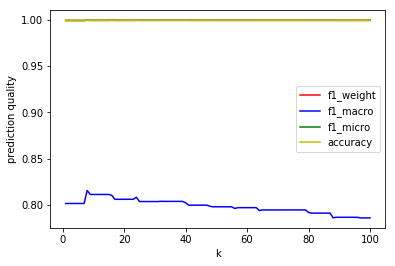

running prediction (latency)...
running prediction (latency)... done
Latency (ms, batch size 6362): 1344.112
Latency (ms) mean for single item: 10.124
Latency (ms) p90 for single item: 11.439
Latency (ms) p99 for single item: 18.003
Deleted knn-latency-ivf-l2-1545342824-189569


In [57]:
import time

#index2estimator = {'flat_l2': knn_estimator_flat_l2, 'ivf_l2': knn_estimator_ivf_l2}
index2estimator = {'ivf_l2': knn_estimator_ivf_l2}

instance_type = 'ml.m4.xlarge'

eval_results = {}

for index in index2estimator:
    estimator = index2estimator[index]
    eval_results[index] = {}
    model_name = 'knn_%s'%(index)
    endpoint_name = 'knn-latency-%s-%s'%(index.replace('_','-'), str(time.time()).replace('.','-'))
    print('\nsetting up endpoint for  index_type=%s' %(index))
    pred = predictor_from_hyperparams(estimator, index, instance_type, endpoint_name=endpoint_name)
    print('')
    print('Running prediction for %s'%(index))
    eval_result = evaluate(pred, test_features, test_labels, model_name=model_name, verbose=True)        
    eval_result['instance'] = instance_type 
    eval_result['index'] = index 
    eval_results[index][instance_type] = eval_result
    delete_endpoint(pred)

So... both models peak with with very similar f1 scores around k=10, but the IVF-clustered one does so at a much lower latency, so that seems to be the one to run with for real use.  Let's get ourselves a reference model built around that lower k value.

In [69]:
low_k_ivf_l2 = {
    'feature_dim': 10,
    'k': 10,
    'sample_size': 1000000,
    'predictor_type': 'classifier',
    'index_type': 'faiss.IVFFlat'
}
output_path_ivf_l2_lowk = 's3://' + bucket + '/' + prefix + '/ivf_l2_lowk/output'
knn_estimator_ivf_l2_lowk = trained_estimator_from_hyperparams(s3_train_data, hyperparams_ivf_l2, output_path_ivf_l2, 
                                                          s3_test_data=s3_test_data)

INFO:sagemaker:Creating training-job with name: knn-2018-12-21-14-48-31-484


2018-12-21 14:48:31 Starting - Starting the training job...
2018-12-21 14:48:34 Starting - Launching requested ML instances......
2018-12-21 14:49:39 Starting - Preparing the instances for training............
2018-12-21 14:51:58 Downloading - Downloading input data
2018-12-21 14:51:58 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[12/21/2018 14:52:00 INFO 139991684052800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[12/21/2018 14:52:00 INFO 139991684052800] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'sample_size

[12/21/2018 14:52:13 INFO 139936671827776] push reservoir to kv... 4 num_workers 0 rank
[12/21/2018 14:52:13 INFO 140415048464192] push reservoir to kv... 4 num_workers 1 rank
[12/21/2018 14:52:13 INFO 140415048464192] ...done (250000)
[12/21/2018 14:52:13 INFO 140415048464192] #progress_metric: host=algo-3, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Number of Batches Since Last Reset": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Number of Records Since Last Reset": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Total Batches Seen": {"count": 1, "max": 1146, "sum": 1146.0, "min": 1146}, "Total Records Seen": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Max Records Seen Between Resets": {"count": 1, "max": 5726358, "sum": 5726358.0, "min": 5726358}, "Reset Count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1545403933.481808, "Di


2018-12-21 14:54:26 Uploading - Uploading generated training model
2018-12-21 14:54:35 Completed - Training job completed
Billable seconds: 695


In [94]:
## Ripped from AWS Blog build-multiclass-classifiers-with-amazon-sagemaker-linear-learner

label_map = {0:'Normal', 1:'Fraud'}

def predict(predictor, test_features):
    # tune the predictor to provide the non-verbose response
    predictor.accept = 'application/json'
    
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    print('\nRunning predictions in batches...')
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    print('Predictions done.')

    # parse protobuf responses to extract predicted labels
    test_preds = np.concatenate([np.array([x['predicted_label'] for x in batch['predictions']]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    return test_preds
    
def evaluate_metrics(test_preds, test_labels):
    # calculate overall scored
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    f1_macro = f1_score(test_labels, test_preds, average='macro')
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1 Score: {:.3f}'.format(f1_macro))

INFO:sagemaker:Creating model with name: knn-2018-12-21-16-06-59-294


Already deleted: knn-eval-ivf-12-1545406334-0686235


INFO:sagemaker:Creating endpoint with name knn-eval-ivf-12-1545408419-2051814


--------------------------------------------------------------------------!
Running predictions in batches...
Predictions done.
Accuracy: 0.999
F1 Score: 0.786
Deleted knn-eval-ivf-12-1545408419-2051814


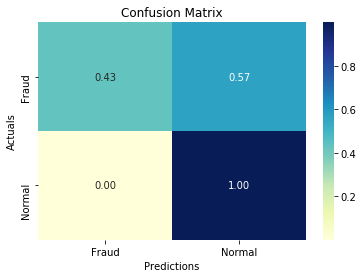

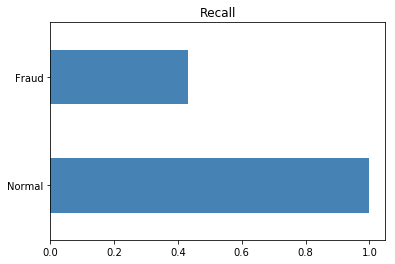

In [95]:
delete_endpoint(pred)
pred = predictor_from_hyperparams(knn_estimator_ivf_l2_lowk,
                                  'eval_ivf_12',
                                  'ml.m4.xlarge',
                                  endpoint_name = 'knn-eval-ivf-12-%s'%(str(time.time()).replace('.','-')))
predicted_labels = predict(pred, test_features)
evaluate_metrics(predicted_labels, test_labels)
delete_endpoint(pred)